In [1]:
import pandas as pd

data=pd.read_csv("/content/drive/MyDrive/Systems Biology/AS5_training_data__X_.csv")
data.head()

,t,X
0,0,1.045260
1,1,0.788169
2,2,0.791501
3,3,0.922868
4,4,1.005286


In [2]:
data['t']

0        0
1        1
2        2
3        3
4        4
      ... 
96      96
97      97
98      98
99      99
100    100
Name: t, Length: 101, dtype: int64

In [3]:
data['t']
type(data['X'])
data['X'].shape

(101,)

# Raw data of X

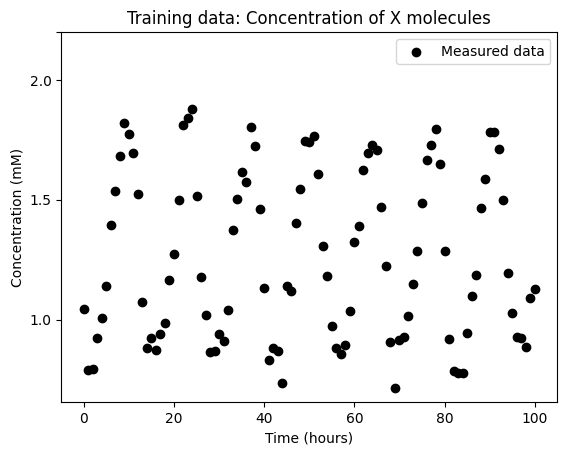

In [4]:
import matplotlib.pyplot as plt
import numpy as np

plt.scatter(data['t'],data['X'],label='Measured data',color='black')
plt.yticks([1.0,1.5,2.0,2.2],labels=[1.0,1.5,2.0,''])
plt.title('Training data: Concentration of X molecules')
plt.xlabel('Time (hours)')
plt.ylabel('Concentration (mM)')
plt.legend()



# With random values

In [5]:
#define function of dx_dt, dy_dt, dz_dt
def dxdydzde(v,t,*param):  
    x,y,z=v #xyz value
    I,a,b,c,d,E,n=param #input, a, b, c, d, enzyme initial, n(z^n/(d+z^n))

    E=((z**n)/(d+z**n))*E #calculate enzyme
    dx=I-a*(E)*x #calculate dx/dt
    dy=a*(E)*x-b*y #calculate dy/dt
    dz=b*y-c*z #calculate dz/dt

    return [dx,dy,dz] #return next [x,y,z] value

In [6]:
pip install pytictoc

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


<ipython-input-5-7caee41b2b97>:6: RuntimeWarning: invalid value encountered in double_scalars
  E=((z**n)/(d+z**n))*E #calculate enzyme
/usr/local/lib/python3.9/dist-packages/scipy/integrate/_odepack_py.py:248: ODEintWarning: Excess accuracy requested (tolerances too small). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/usr/local/lib/python3.9/dist-packages/scipy/integrate/_odepack_py.py:248: ODEintWarning: Illegal input detected (internal error). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


92858 92958
Elapsed time is 346.677887 seconds.


Text(0.5, 1.0, 'Best parameter set: a=2.2, b=0.94, c=0.98, d=1.14, n=2.91, RMSE=0.07')

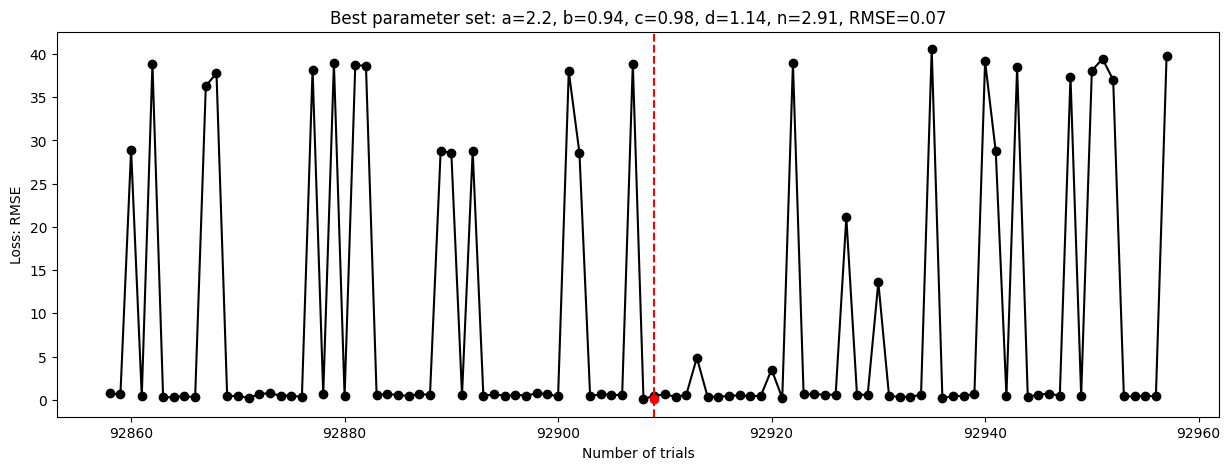

In [24]:
import random
from scipy.integrate import odeint #odeint import
import math
from pytictoc import TicToc

# TicToc class
time = TicToc()

time.tic()
N=100000 # set the number of estimation trials
np.random.seed(10) # make random data reproducible

observed_y= data['X']
t=np.arange(0,101)

RMSE=[] #list of RMSE

#randomly choose the a b c d n values
a = np.random.uniform(size=N,low=1.6, high=2.5)
b = np.random.uniform(size=N,low=0.9, high=1.0)
c = np.random.uniform(size=N,low=0.9, high=1.0)
d = np.random.uniform(size=N,low=0.5, high=1.2)
n = np.random.uniform(size=N,low=2, high=4)

for i in range(0,N): 

    y0=np.array([1,1,1]) #[X,Y,Z] #initial value
    params=np.array([0.75,a[i],b[i],c[i],d[i],1,n[i]]) #[I,a,b,c,d,ei,n] #parameter
    param=tuple(params) #change 'params' array to tuple

    x=np.arange(0,101)
    y=odeint(dxdydzde,y0,t,args=param)
    RMSE.append(np.sqrt(np.square(np.subtract(observed_y, y[:,0])).mean())) #append RMSE values

minimum=min(RMSE) #find minimum value of MSE
min_index=np.argmin(RMSE) #find the index of MSE
best_params=[a[min_index].round(2),b[min_index].round(2),c[min_index].round(2),d[min_index].round(2),n[min_index].round(2)]

#cut the range of x because it is too large
xmin = min_index - 50
xmax = min_index + 50
print(xmin, xmax)
xaxis=np.arange(0,N)[xmin:xmax]

time.toc()

#plot
plt.figure(figsize=(15,5))
plt.plot(xaxis,RMSE[xmin:xmax],marker='o',color='black')
plt.axvline(min_index+1, 0, 1000, color='red', linestyle='--')
plt.plot (min_index+1,minimum,'ro')
plt.ylabel('Loss: RMSE')
plt.xlabel('Number of trials')
plt.title(f'Best parameter set: a={best_params[0]}, b={best_params[1]}, c={best_params[2]}, d={best_params[3]}, n={best_params[4]}, RMSE={minimum.round(2)}')

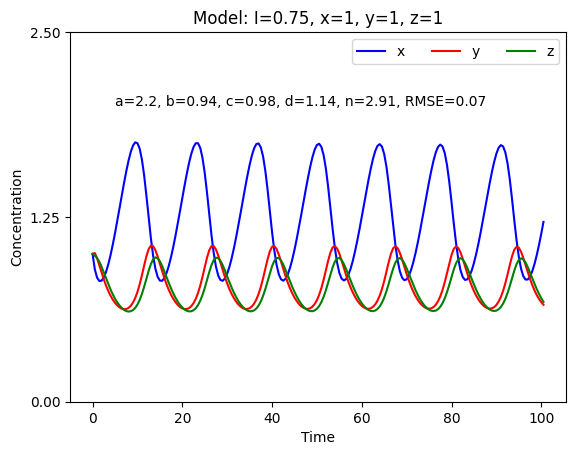

In [25]:
t=np.arange(0,101,0.5)
y0=np.array([1,1,1])
bestt_params=np.array([0.75,best_params[0],best_params[1],best_params[2],best_params[3],1,best_params[4]])
b_params=tuple(bestt_params)
y=odeint(dxdydzde,y0,t,args=b_params)

plt.plot(t,y[:,0],label='x',color='b')
plt.plot(t,y[:,1],label='y',color='r')
plt.plot(t,y[:,2],label='z',color='g')

plt.xlabel("Time")
plt.ylabel("Concentration")
plt.title(f'Model: I=0.75, x=1, y=1, z=1')
plt.text(5,2.0,f'a={best_params[0]}, b={best_params[1]}, c={best_params[2]}, d={best_params[3]}, n={best_params[4]}, RMSE={minimum.round(2)}')
plt.yticks(np.arange(0, 2.6, 1.25))
plt.legend(ncol=3)

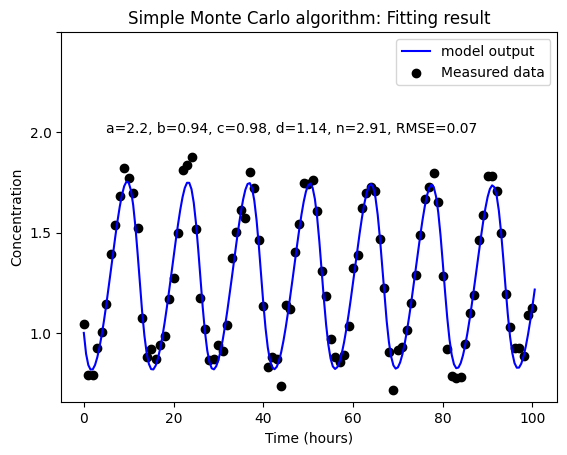

In [26]:
plt.plot(t,y[:,0],label='model output',color='b')
plt.scatter(data['t'],data['X'],label='Measured data',color='black')
plt.yticks([1.0,1.5,2.0,2.5],labels=[1.0,1.5,2.0,''])
plt.title(f'Simple Monte Carlo algorithm: Fitting result')
plt.text(5,2.0,f'a={best_params[0]}, b={best_params[1]}, c={best_params[2]}, d={best_params[3]}, n={best_params[4]}, RMSE={minimum.round(2)}')
plt.xlabel("Time (hours)")
plt.ylabel("Concentration")
plt.legend()

plt.show()


# Simulated Annealing algorithm (own parameter range)

Elapsed time is 40.740478 seconds.


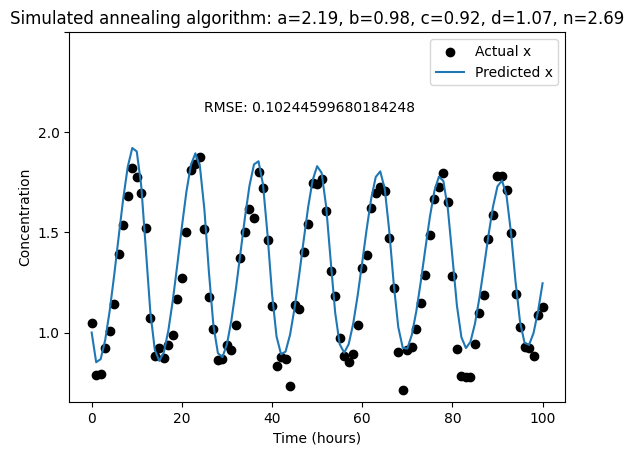

In [54]:
import numpy as np
from scipy.optimize import minimize
from scipy.integrate import odeint
import matplotlib.pyplot as plt

time = TicToc()
time.tic()

#set the random seed
np.random.seed(4)

# set the initial values
x0 = 1
y0 = 1
z0 = 1
v0 = [x0, y0, z0]

#data import
t=data['t']
y=data['X']


#define function of dx_dt, dy_dt, dz_dt
def dxdydzde(v,t,*param):  
    x,y,z=v #xyz value
    I,E,a,b,c,d,n=param #input, a, b, c, d, enzyme initial, n(z^n/(d+z^n))

    E=((z**n)/(d+z**n))*E #calculate enzyme
    dx=I-a*(E)*x #calculate dx/dt
    dy=a*(E)*x-b*y #calculate dy/dt
    dz=b*y-c*z #calculate dz/dt

    return [dx,dy,dz] #return next [x,y,z] value

# Define the objective function
def objective_function(params):
    a, b, c, d, n = params
    I = 0.75
    E = 1
    para = (I, a, b, c, d, E, n)
    v = odeint(dxdydzde, v0, t, args=para)
    x = v[:, 0]
    rmse = np.sqrt(np.mean((y - x)**2)) 
    return rmse

# Define ranges for the parameters
ranges = [(1.6, 2.5), (0.9, 1.0), (0.9, 1.0), (0.5, 1.2), (2, 4)]

# Define the initial guess for the input parameters
initial_guess = [1, 1, 1, 1, 1]

# Set the maximum number of iterations for the simulated annealing algorithm
max_iter = 1000

# Set the cooling rate for the simulated annealing algorithm
cooling_rate = 0.95

# Set the initial temperature for the simulated annealing algorithm
initial_temperature = 10

# Define the function to update the temperature in the simulated annealing algorithm
def update_temperature(temperature):
    return cooling_rate * temperature

# Initialize variables for storing RMSE and best params
rmse_list = []
best_params = None

# Define the function to generate a new candidate params in the simulated annealing algorithm
def make_new_params(current_params, temperature):
    new_params = []
    for i in range(len(current_params)):
        new_value = current_params[i] + np.random.normal(0, temperature) #updating with the temperature

        #check new parameter value is in range.
        if new_value < ranges[i][0]:
            new_value = ranges[i][0]
        elif new_value > ranges[i][1]:
            new_value = ranges[i][1]

        new_params.append(new_value)
    return new_params

#set the initial values
temperature = initial_temperature
current_params = initial_guess
best_params = current_params

# Run the simulated annealing algorithm
for i in range(max_iter):
    new_params = make_new_params(current_params, temperature)
    #calculate current error
    current_error = objective_function(current_params) 

    #calculate new error
    new_error = objective_function(new_params)

    #if new error is less than current error, update the current params and best params.
    if new_error < current_error:
        current_params = new_params
        if new_error < objective_function(best_params):
            best_params = new_params
    
    # By using the probability, choose new parameters or not
    else:
        delta_error = new_error - current_error

        #calculate probability
        acceptance_probability = np.exp(-delta_error / temperature) 
        if np.random.random() < acceptance_probability:
            current_params = new_params
    temperature = update_temperature(temperature)


    # Store the RMSE at the current iteration
    rmse_list.append(objective_function(current_params))

    # Update the best params if necessary
    if best_params is None or objective_function(current_params) < objective_function(best_params):
        best_params = current_params

time.toc()

# Generate a plot of the actual x and predicted x
para = (0.75, best_params[0], best_params[1], best_params[2], best_params[3], 1, best_params[4])
v = odeint(dxdydzde, v0, t, args=para)
x_pred = v[:, 0]
plt.scatter(t, y, label='Actual x',color='black')
plt.plot(t, x_pred, label='Predicted x')
plt.title(f'Simulated annealing algorithm: a={round(best_params[0],2)}, b={round(best_params[1],2)}, c={round(best_params[2],2)}, d={round(best_params[3],2)}, n={round(best_params[4],2)}')
plt.text(25,2.1,f'RMSE: {objective_function(best_params)}')
plt.yticks([1.0,1.5,2.0,2.5],labels=[1.0,1.5,2.0,''])
plt.xlabel("Time (hours)")
plt.ylabel("Concentration")
plt.legend()
plt.show()


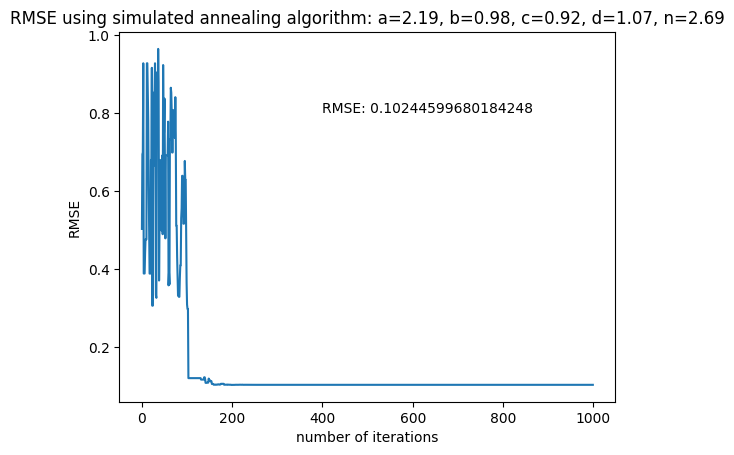

In [55]:
plt.plot(range(len(rmse_list)), rmse_list)
plt.xlabel('number of iterations')
plt.ylabel('RMSE')
plt.text(400,0.8,f'RMSE: {objective_function(best_params)}')
plt.title(f'RMSE using simulated annealing algorithm: a={round(best_params[0],2)}, b={round(best_params[1],2)}, c={round(best_params[2],2)}, d={round(best_params[3],2)}, n={round(best_params[4],2)}')
plt.show()

# Simulated Annealing algorithm (parameter range with d=1)

Elapsed time is 33.058308 seconds.


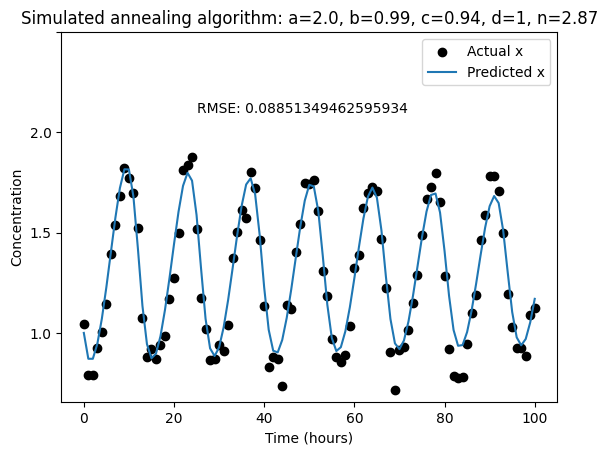

In [56]:
import numpy as np
from scipy.optimize import minimize
from scipy.integrate import odeint
import matplotlib.pyplot as plt

time=TicToc()
time.tic()

#set the random seed
np.random.seed(4)

# set the initial values
x0 = 1
y0 = 1
z0 = 1
v0 = [x0, y0, z0]

#data import
t=data['t']
y=data['X']


#define function of dx_dt, dy_dt, dz_dt
def dxdydzde(v,t,*param):  
    x,y,z=v #xyz value
    I,E,a,b,c,d,n=param #input, a, b, c, d, enzyme initial, n(z^n/(d+z^n))

    E=((z**n)/(d+z**n))*E #calculate enzyme
    dx=I-a*(E)*x #calculate dx/dt
    dy=a*(E)*x-b*y #calculate dy/dt
    dz=b*y-c*z #calculate dz/dt

    return [dx,dy,dz] #return next [x,y,z] value

# Define the objective function
def objective_function(params):
    a, b, c, d, n = params
    I = 0.75
    E = 1
    para = (I, a, b, c, d, E, n)
    v = odeint(dxdydzde, v0, t, args=para)
    x = v[:, 0]
    rmse = np.sqrt(np.mean((y - x)**2)) 
    return rmse

# Define ranges for the parameters
ranges = [(1.6, 2.5), (0.9, 1.0), (0.9, 1.0), (1, 1), (2, 4)]

# Define the initial guess for the input parameters
initial_guess = [1, 1, 1, 1, 1]

# Set the maximum number of iterations for the simulated annealing algorithm
max_iter = 1000

# Set the cooling rate for the simulated annealing algorithm
cooling_rate = 0.95

# Set the initial temperature for the simulated annealing algorithm
initial_temperature = 10

# Define the function to update the temperature in the simulated annealing algorithm
def update_temperature(temperature):
    return cooling_rate * temperature

# Initialize variables for storing RMSE and best params
rmse_list = []
best_params = None

# Define the function to generate a new candidate params in the simulated annealing algorithm
def make_new_params(current_params, temperature):
    new_params = []
    for i in range(len(current_params)):
        new_value = current_params[i] + np.random.normal(0, temperature) #updating with the temperature

        #check new parameter value is in range.
        if new_value < ranges[i][0]:
            new_value = ranges[i][0]
        elif new_value > ranges[i][1]:
            new_value = ranges[i][1]

        new_params.append(new_value)
    return new_params

#set the initial values
temperature = initial_temperature
current_params = initial_guess
best_params = current_params

# Run the simulated annealing algorithm
for i in range(max_iter):
    new_params = make_new_params(current_params, temperature)
    #calculate current error
    current_error = objective_function(current_params) 

    #calculate new error
    new_error = objective_function(new_params)

    #if new error is less than current error, update the current params and best params.
    if new_error < current_error:
        current_params = new_params
        if new_error < objective_function(best_params):
            best_params = new_params
    
    # By using the probability, choose new parameters or not
    else:
        delta_error = new_error - current_error

        #calculate probability
        acceptance_probability = np.exp(-delta_error / temperature) 
        if np.random.random() < acceptance_probability:
            current_params = new_params
    temperature = update_temperature(temperature)


    # Store the RMSE at the current iteration
    rmse_list.append(objective_function(current_params))

    # Update the best params if necessary
    if best_params is None or objective_function(current_params) < objective_function(best_params):
        best_params = current_params

time.toc()

# Generate a plot of the actual x and predicted x
para = (0.75, best_params[0], best_params[1], best_params[2], best_params[3], 1, best_params[4])
v = odeint(dxdydzde, v0, t, args=para)
x_pred = v[:, 0]
plt.scatter(t, y, label='Actual x',color='black')
plt.plot(t, x_pred, label='Predicted x')
plt.title(f'Simulated annealing algorithm: a={round(best_params[0],2)}, b={round(best_params[1],2)}, c={round(best_params[2],2)}, d={round(best_params[3],2)}, n={round(best_params[4],2)}')
plt.text(25,2.1,f'RMSE: {objective_function(best_params)}')
plt.yticks([1.0,1.5,2.0,2.5],labels=[1.0,1.5,2.0,''])
plt.xlabel("Time (hours)")
plt.ylabel("Concentration")
plt.legend()
plt.show()


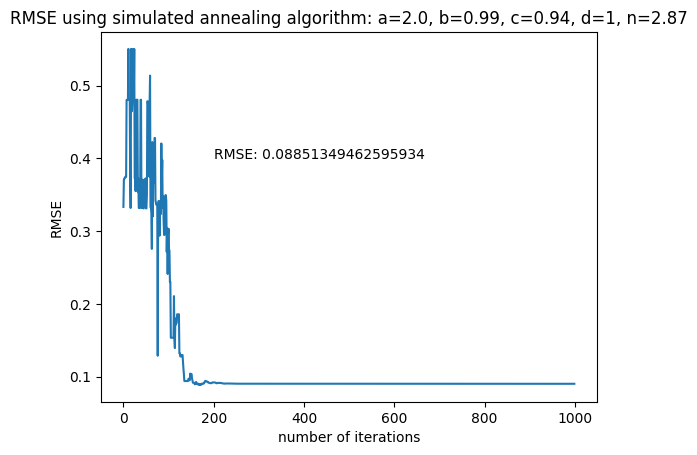

In [57]:
plt.plot(range(len(rmse_list)), rmse_list)
plt.xlabel('number of iterations')
plt.ylabel('RMSE')
plt.text(200,0.4,f'RMSE: {objective_function(best_params)}')
plt.title(f'RMSE using simulated annealing algorithm: a={round(best_params[0],2)}, b={round(best_params[1],2)}, c={round(best_params[2],2)}, d={round(best_params[3],2)}, n={round(best_params[4],2)}')
plt.show()